In [24]:
# imports
import re
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from time import time
from wordcloud import WordCloud,STOPWORDS
from sklearn.utils import shuffle


In [25]:
# methods
def get_features(matrix,results):
    new_list = []
    new_results = []
    removed = []
    for i in range(len(matrix)):
        if(matrix[i] == matrix[i]):
            result = matrix[i].lower().translate(str.maketrans("","", string.punctuation))
            new_list.append(result)
            new_results.append(int(results[i]))
        else:
            removed.append(i)
    return new_list,new_results,removed

def get_features_test(matrix):
    new_list = []
    for i in range(len(matrix)):
        if(matrix[i] == matrix[i]):
            result = matrix[i].lower().translate(str.maketrans("","", string.punctuation))
            new_list.append(result)
        else:
            new_list.append("")         
    return new_list

## Dataset1

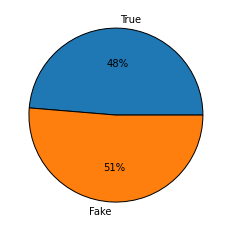

No. of unusable data (missing or wrongly formatted): 558


In [26]:
train = pd.read_csv("train.csv")
train_text = train["title"].to_numpy()
train_results = train["label"]
# print(train_text)
train_text,train_results,removed=get_features(train_text, train_results)

plt.pie([sum(train_results),len(train_results)-sum(train_results)],labels = ["True","Fake"], autopct='%1.1i%%', wedgeprops={"edgecolor":"0",'linewidth': 1,
                    'linestyle': 'solid', 'antialiased': True})
plt.show()
print("No. of unusable data (missing or wrongly formatted):",len(removed))

In [4]:
train_results = np.array(train_results)
vocab_size = 10000
encoding = [one_hot(i, vocab_size) for i in train_text]

m = len(max(train_text, key = len))
padded = pad_sequences(encoding, padding = 'pre')

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim = 40, input_length=m))
model.add(LSTM(150))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit(padded, train_results, epochs = 3, validation_split=0.1)
model.evaluate(padded, train_results)
model.save('LSTM_D1')


Epoch 1/3
570/570 [==============================] - 37s 65ms/step - loss: 0.2366 - accuracy: 0.8990 - val_loss: 0.1738 - val_accuracy: 0.9230
Epoch 2/3
570/570 [==============================] - 36s 63ms/step - loss: 0.0987 - accuracy: 0.9649 - val_loss: 0.1839 - val_accuracy: 0.9274
Epoch 3/3
633/633 [==============================] - 13s 20ms/step - loss: 0.0390 - accuracy: 0.9896
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: LSTM_D1\assets


In [5]:
test = pd.read_csv("test.csv")
test_text = test["title"].to_numpy()
test_text=get_features_test(test_text)

vocab_size = 10000
encoding = [one_hot(str(i), vocab_size) for i in test_text]

padded = pad_sequences(encoding, padding = 'pre', maxlen = m)

ypred = model.predict(padded)
pred = (ypred>0.5).astype('int')
mysubmit = pd.DataFrame(data = pred,columns = ['label'])
mysubmit['id'] = test['id']
mysubmit.to_csv("sub_lstm.csv",columns=["id","label"],index=False)


### CNN

In [27]:
train_results = np.array(train_results)
cv=CountVectorizer(min_df=10,ngram_range=(1,2))
padded=cv.fit_transform(train_text)
padded.sort_indices()
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = padded.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.fit(padded,train_results , epochs = 5)
model.save('CNN_D1')

Epoch 1/5
633/633 [==============================] - 3s 5ms/step - loss: 0.3616 - accuracy: 0.9024
Epoch 2/5
633/633 [==============================] - 3s 4ms/step - loss: 0.2537 - accuracy: 0.9421
Epoch 3/5
633/633 [==============================] - 2s 4ms/step - loss: 0.1849 - accuracy: 0.9607
Epoch 4/5
633/633 [==============================] - 3s 5ms/step - loss: 0.1409 - accuracy: 0.9706
Epoch 5/5
633/633 [==============================] - 3s 4ms/step - loss: 0.1141 - accuracy: 0.9756
INFO:tensorflow:Assets written to: CNN_D1\assets


In [7]:
test = pd.read_csv("test.csv")
test_text = test["title"].to_numpy()
test_text=get_features_test(test_text)
padded=cv.transform(test_text)
padded.sort_indices()
ypred = model.predict(padded)
pred = (ypred>0.5).astype('int')



In [8]:
mysubmit = pd.DataFrame(data = pred,columns = ['label'])
mysubmit['id'] = test['id']
mysubmit.to_csv("sub_cnn.csv",columns=["id","label"],index=False)

## Dataset2


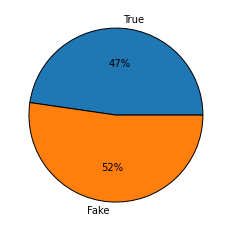

No. of unusable data (missing or wrongly formatted): 0


In [9]:
true_data = pd.read_csv("True.csv")
fake_data = pd.read_csv("Fake.csv")
labels = [1 for i in range(len(true_data))] + [0 for i in range(len(fake_data))]
train_data = pd.concat([true_data,fake_data])
train_data["label"] = labels
train_data = shuffle(train_data)

train_text = train_data["title"].to_numpy()
train_results = train_data["label"].to_numpy()
train_text,train_results,removed=get_features(train_text, train_results)
train_results = np.array(train_results)

plt.pie([sum(train_results),len(train_results)-sum(train_results)],labels = ["True","Fake"], autopct='%1.1i%%', wedgeprops={"edgecolor":"0",'linewidth': 1,
                    'linestyle': 'solid', 'antialiased': True})
plt.show()
print("No. of unusable data (missing or wrongly formatted):",len(removed))






True word cloud


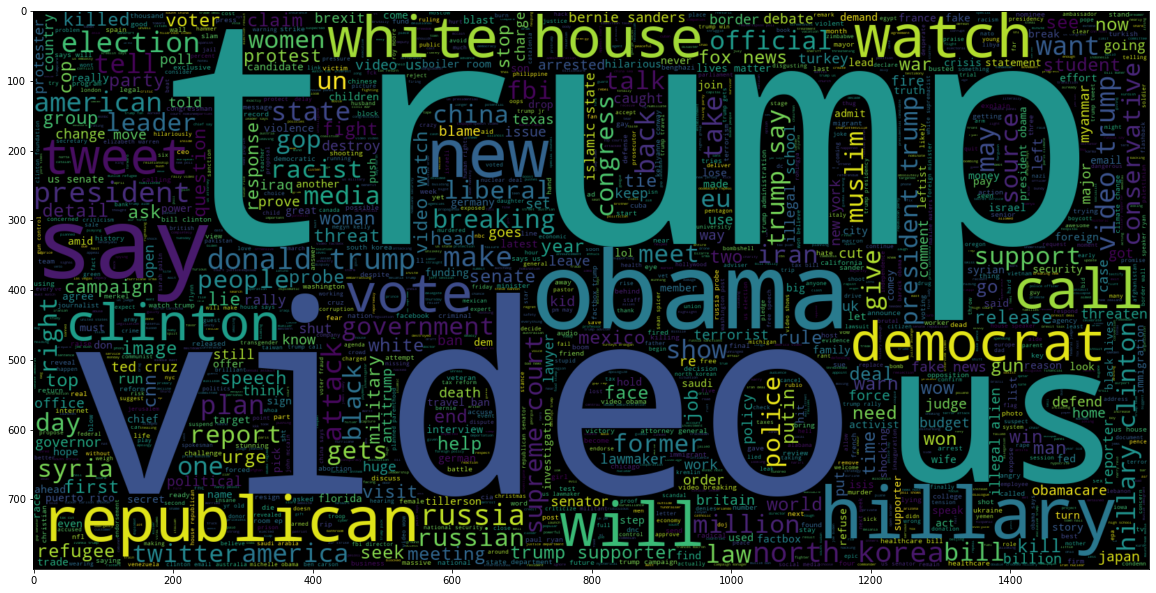

In [10]:
print("True word cloud")
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(train_text[:len(true_data)]))
plt.imshow(wc , interpolation = 'bilinear')

Fake word cloud


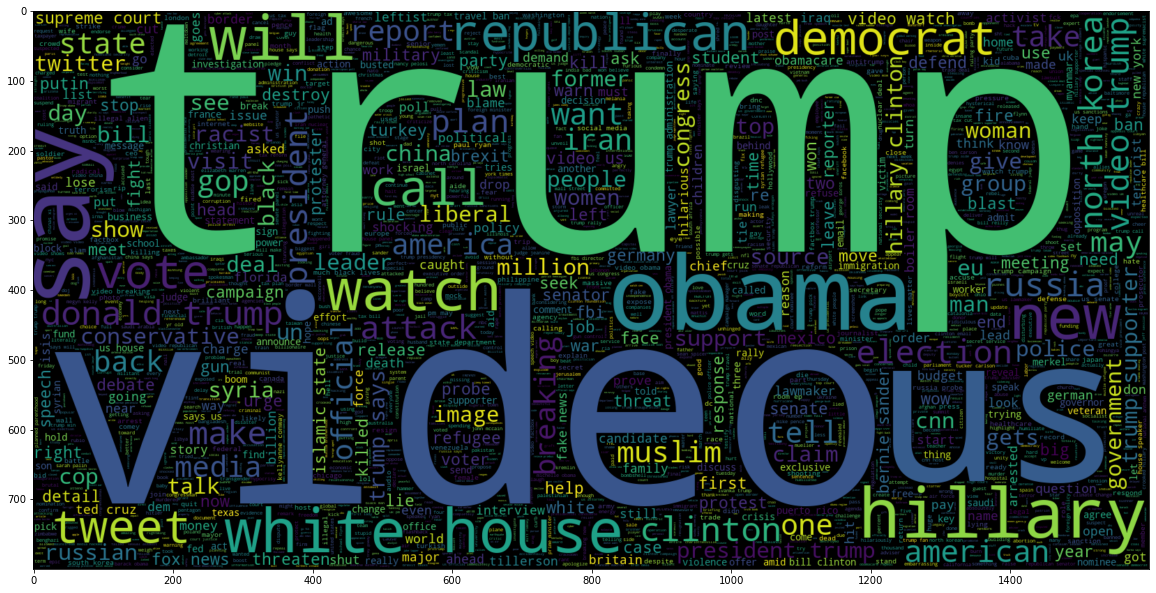

In [11]:
print("Fake word cloud")
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(train_text[len(true_data)+1:]))
plt.imshow(wc , interpolation = 'bilinear')

We can clearly see that the training and testing data for this is very similar. SO the fake news will be very convincing and harder to detect. Therefore we skip lemmatization and stemming keep the slight distinctions in the datasets.

In [12]:
vocab_size = 10000
encoding = [one_hot(i, vocab_size) for i in train_text]

m = len(max(train_text, key = len))
padded = pad_sequences(encoding, padding = 'pre')

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim = 40, input_length=m))
model.add(LSTM(150))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
plot_model(model)
model.fit(padded, train_results, epochs = 3, validation_split=0.1)
model.evaluate(padded, train_results)
model.save('LSTM_D2')


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Epoch 1/3
1263/1263 [==============================] - 57s 45ms/step - loss: 0.1387 - accuracy: 0.9455 - val_loss: 0.0942 - val_accuracy: 0.9679
Epoch 2/3
1263/1263 [==============================] - 52s 41ms/step - loss: 0.0538 - accuracy: 0.9812 - val_loss: 0.0952 - val_accuracy: 0.9686
Epoch 3/3
1404/1404 [==============================] - 22s 16ms/step - loss: 0.0222 - accuracy: 0.9935
INFO:tensorflow:Assets written to: LSTM_D2\assets


### CNN

In [17]:
cv=CountVectorizer(min_df=10,ngram_range=(1,2))
padded=cv.fit_transform(train_text)
padded.sort_indices()

In [18]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = padded.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.fit(padded,train_results , epochs = 5)

Epoch 1/5
1404/1404 [==============================] - 11s 8ms/step - loss: 0.1357 - accuracy: 0.9490
Epoch 2/5
1404/1404 [==============================] - 12s 8ms/step - loss: 0.0430 - accuracy: 0.9836
Epoch 3/5
1404/1404 [==============================] - 11s 8ms/step - loss: 0.0144 - accuracy: 0.9943
Epoch 4/5
1404/1404 [==============================] - 11s 8ms/step - loss: 0.0047 - accuracy: 0.9985
Epoch 5/5
1404/1404 [==============================] - 11s 8ms/step - loss: 0.0021 - accuracy: 0.9993


In [19]:
model.save('CNN_D2')

INFO:tensorflow:Assets written to: CNN_D2\assets


In [ ]:
# loading models
model_CNN = tf.keras.models.load_model('CNN')
model_LSTM = tf.keras.models.load_model('LSTM')

